In [1]:
# Run this in a new notebook cell
import torch

if torch.cuda.is_available():
    print(f"SUCCESS! GPU is available.")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
    print("You are ready to train.")
else:
    print("--- ERROR: GPU is still NOT available ---")
    print("Something went wrong with the installation.")

SUCCESS! GPU is available.
Device Name: NVIDIA GeForce RTX 4060 Ti
You are ready to train.


In [2]:
data_config_path = 'D:\COS40007\pothole_detection\data.yaml'

In [3]:
from ultralytics import YOLO

def main():
    # 1. Build the GHOST-YOLO11 model
    # This creates a new model with random weights based on your YAML
    model = YOLO("yolo11n_ghost.yaml") 

    # 2. Train
    # Since we are training from scratch (random weights),
    # we need more epochs (e.g., 100-200) compared to transfer learning.
    results = model.train(
        data= data_config_path,               # Your dataset config
        epochs=150,                     # Train longer for scratch models
        imgsz=640,                      # Standard YOLO image size
        batch=16,                       # Reduce if you run out of GPU memory
        name="yolo11_ghost_pothole",    # Project name
        optimizer='AdamW',              # AdamW is often better for scratch training
        lr0=0.001                       # Slightly higher initial learning rate for scratch
    )

if __name__ == '__main__':
    main()

New https://pypi.org/project/ultralytics/8.3.233 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.217  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16380MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\COS40007\pothole_detection\data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n_ghost.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name


🏆 BEST PERFORMANCE (Epoch 127)
   • mAP@50 (Accuracy):      91.38%  (Target: >80%)
   • mAP@50-95 (Precision):  59.76%  (Target: >50%)

📉 LOSS STATISTICS
   • Initial Box Loss:       3.7005
   • Final Box Loss:         1.0021
   • Loss Reduction:         72.9% (Higher is better)


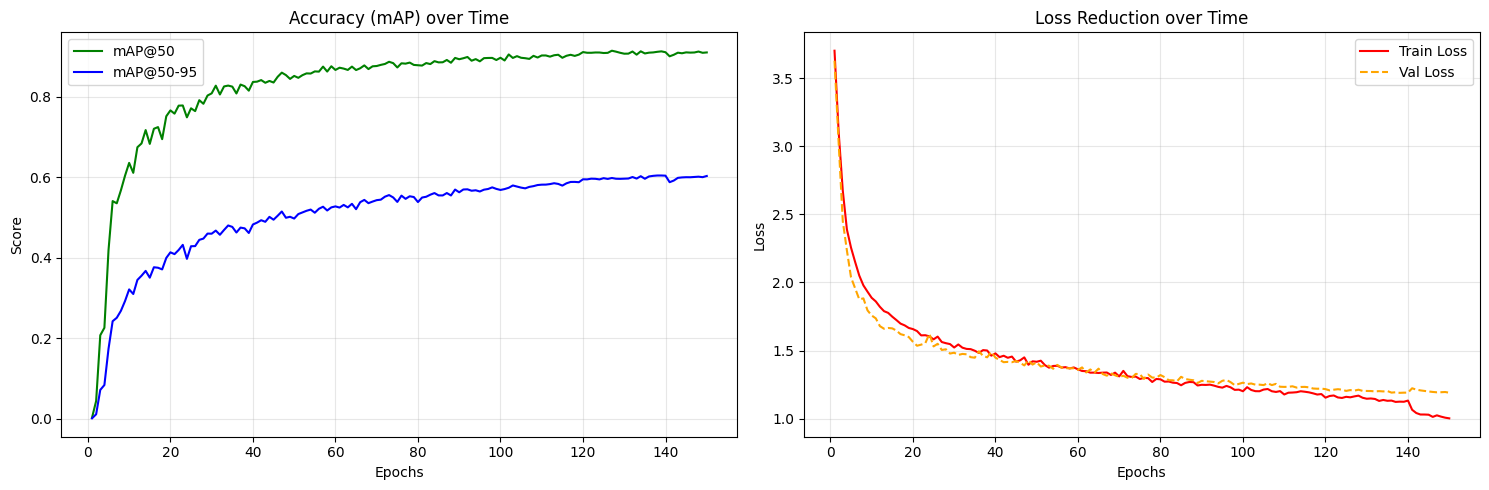


📦 MODEL ARCHITECTURE INFO
YOLO11n_ghost summary: 231 layers, 2,038,243 parameters, 0 gradients, 6.1 GFLOPs


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os


# SETUP PATHS (Update this to your actual folder!)


run_folder = r"D:\COS40007\pothole_detection\runs\detect\yolo11_ghost_pothole3"

results_csv = os.path.join(run_folder, "results.csv")
best_weight = os.path.join(run_folder, "weights", "best.pt")


# LOAD & ANALYZE TRAINING DATA

if os.path.exists(results_csv):
    # Load data
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip() # Clean column names

    #  mAP SCORES
    # Get the row with the highest mAP@50
    best_epoch = df.loc[df['metrics/mAP50(B)'].idxmax()]
    best_map50 = best_epoch['metrics/mAP50(B)']
    best_map95 = best_epoch['metrics/mAP50-95(B)']

    print(f"\n BEST PERFORMANCE (Epoch {int(best_epoch['epoch'])})")
    print(f"   • mAP@50 (Accuracy):      {best_map50:.2%}  (Target: >80%)")
    print(f"   • mAP@50-95 (Precision):  {best_map95:.2%}  (Target: >50%)")

    # --- B. LOSS REDUCTION ---
    # Compare first epoch vs last epoch to see how much it learned
    first_loss = df.iloc[0]['train/box_loss']
    last_loss = df.iloc[-1]['train/box_loss']
    loss_reduction = ((first_loss - last_loss) / first_loss) * 100

    print(f"\nLOSS STATISTICS")
    print(f"   • Initial Box Loss:       {first_loss:.4f}")
    print(f"   • Final Box Loss:         {last_loss:.4f}")
    print(f"   • Loss Reduction:         {loss_reduction:.1f}% (Higher is better)")

    # --- PLOT CURVES ---
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Plot mAP
    ax[0].plot(df['epoch'], df['metrics/mAP50(B)'], color='green', label='mAP@50')
    ax[0].plot(df['epoch'], df['metrics/mAP50-95(B)'], color='blue', label='mAP@50-95')
    ax[0].set_title('Accuracy (mAP) over Time')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Score')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot Loss
    ax[1].plot(df['epoch'], df['train/box_loss'], color='red', label='Train Loss')
    ax[1].plot(df['epoch'], df['val/box_loss'], color='orange', linestyle='--', label='Val Loss')
    ax[1].set_title('Loss Reduction over Time')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

else:
    print(f"❌ Could not find results.csv at {results_csv}")

# ======================================================
# 3. MODEL PARAMETER SIZE
# ======================================================
print(f"\nMODEL ARCHITECTURE INFO")
if os.path.exists(best_weight):
    model = YOLO(best_weight)
    
    # This prints the detailed layer breakdown and param count
    model.info()
    
    # You can also access the numbers directly if needed:
    # n_params = sum(p.numel() for p in model.model.parameters())
    # print(f"   • Total Parameters:       {n_params:,}")
else:
    print(f"❌ Could not find weights at {best_weight}")

## Test Set Evaluation

Evaluate the Ghost YOLO11n model on the test set to get final performance metrics.

In [4]:
# Test the Ghost YOLO11n model on test set
from ultralytics import YOLO

# Load the best Ghost model
best_model_path = r"D:\COS40007\pothole_detection\runs\detect\yolo11_ghost_pothole3\weights\best.pt"
ghost_model = YOLO(best_model_path)

print("Evaluating Ghost YOLO11n on test set...")
print("="*60)

# Run validation on test split
test_metrics = ghost_model.val(
    data='data.yaml',
    split='test',
    batch=16,
    imgsz=640,
    device=0,
    save_json=True,
    plots=True
)

print("\n" + "="*60)
print("GHOST YOLO11N TEST RESULTS")
print("="*60)
print(f"mAP@0.5:      {test_metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {test_metrics.box.map:.4f}")
print(f"Precision:    {test_metrics.box.mp:.4f}")
print(f"Recall:       {test_metrics.box.mr:.4f}")
print("="*60)

Evaluating Ghost YOLO11n on test set...
Ultralytics 8.3.217  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16380MiB)
Ultralytics 8.3.217  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16380MiB)
YOLO11n_ghost summary (fused): 141 layers, 2,031,827 parameters, 0 gradients, 6.0 GFLOPs
YOLO11n_ghost summary (fused): 141 layers, 2,031,827 parameters, 0 gradients, 6.0 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 230.7161.6 MB/s, size: 61.8 KB)
val: Scanning D:\COS40007\pothole_detection\test\labels.cache... 216 images, 23 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 216/216  0.0s
val: Fast image access  (ping: 0.00.0 ms, read: 230.7161.6 MB/s, size: 61.8 KB)
val: Scanning D:\COS40007\pothole_detection\test\labels.cache... 216 images, 23 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 216/216  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 14/14 4.1it/s 3.4s0.3s
                 Cl

## Visual Inference Examples

Test the model on sample images to see detection quality.

Running inference on 6 test images...


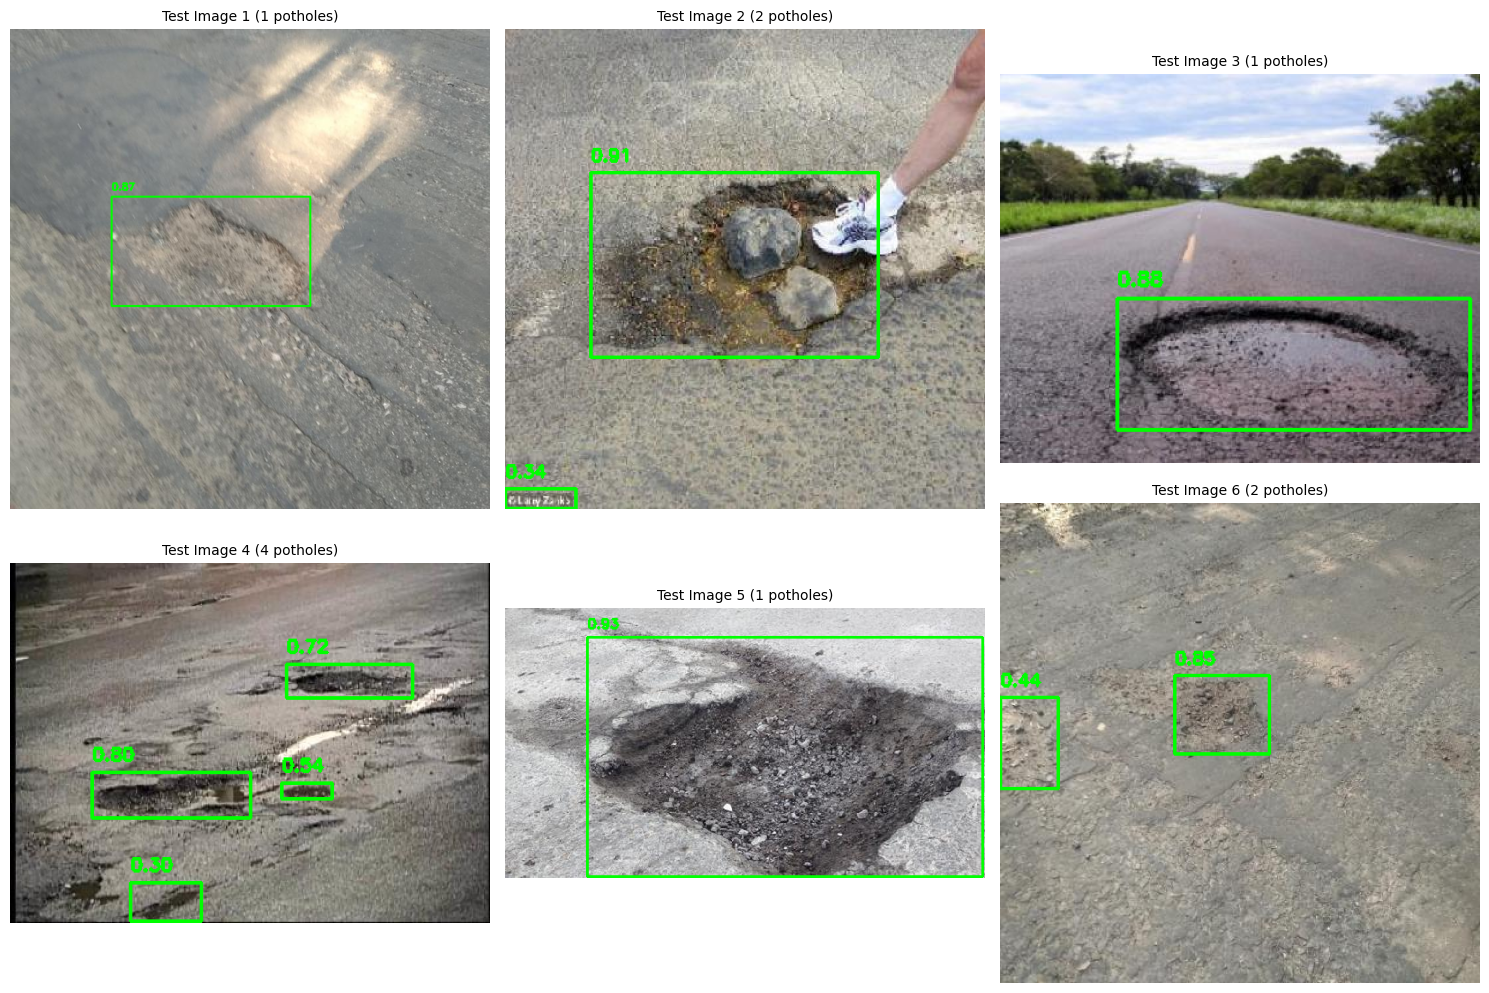


✓ Inference examples saved to: runs/detect/yolo11_ghost_pothole3/test_inference_examples.png


In [5]:
# Run inference on sample test images
import random
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np

# Get random test images
test_images_dir = Path('test/images')
test_image_paths = list(test_images_dir.glob('*.jpg'))
sample_images = random.sample(test_image_paths, min(6, len(test_image_paths)))

print(f"Running inference on {len(sample_images)} test images...")

# Run predictions
results = ghost_model.predict(
    source=sample_images,
    conf=0.25,
    iou=0.45,
    save=False,
    verbose=False
)

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (result, img_path) in enumerate(zip(results, sample_images)):
    # Load original image
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Draw bounding boxes
    if len(result.boxes) > 0:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
            conf = float(box.conf[0])
            
            # Draw rectangle and confidence
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = f'{conf:.2f}'
            cv2.putText(img_rgb, label, (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Display
    axes[idx].imshow(img_rgb)
    axes[idx].axis('off')
    axes[idx].set_title(f'Test Image {idx+1} ({len(result.boxes)} potholes)', fontsize=10)

plt.tight_layout()
plt.savefig('runs/detect/yolo11_ghost_pothole3/test_inference_examples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Inference examples saved to: runs/detect/yolo11_ghost_pothole3/test_inference_examples.png")